In [50]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
words = open("names.txt", "r").read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [3]:
chars = sorted(list(set("".join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi["."] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [7]:
block_size =3

def build_dataset(words):
    X,Y = [],[]

    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182441, 3]) torch.Size([182441])
torch.Size([22902, 3]) torch.Size([22902])
torch.Size([22803, 3]) torch.Size([22803])


In [118]:
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(214783647)
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size,n_hidden), generator=g) * (5/3) / ((n_embd * block_size *n_hidden)**0.5)#* 0.2
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden,vocab_size), generator=g) * 0.01 # make it smaller, we don't want to set weights to exactly zero
b2 = torch.randn(vocab_size, generator=g) * 0 # init to zero

bngain = torch.ones((1, n_hidden))
bnbias= torch.zeros((1, n_hidden))

bnstd_running = torch.ones((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))


parameters = [C,W1#,b1
              ,W2,b2,bngain,bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True


12097


In [80]:
(torch.randn(10000) * 0.2).std()

tensor(0.2013)

In [82]:
(5/3)/ (30**0.5)

0.3042903097250923

tensor(0.0126) tensor(1.0052)
tensor(-0.0006) tensor(1.0065)


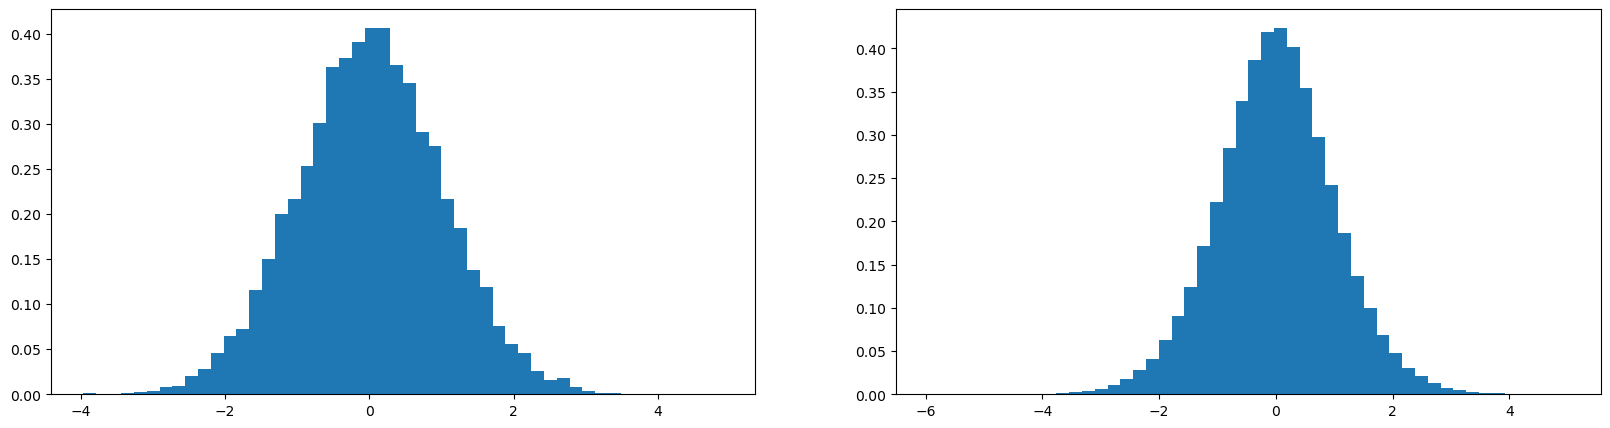

In [74]:
x = torch.randn(1000,10)
w = torch.randn(10,200) / 10**0.5
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

In [90]:
hpract.shape

torch.Size([32, 200])

In [93]:
hpract.mean(0, keepdim=True).shape

torch.Size([1, 200])

In [94]:
hpract.std(0, keepdim=True).shape

torch.Size([1, 200])

In [119]:
max_steps = 200000
batch_size = 32
lossi = []
for i in range(max_steps):

    # minibatch
    ix = torch.randint(0,Xtr.shape[0],(batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    emb = C[Xb]
    embcat = emb.view(emb.shape[0],-1)
    hpract = embcat @ W1 #+ b1
    bnstdi = hpract.std(0, keepdim=True)
    bnmeani = hpract.mean(0, keepdim=True)
    hpract = bngain *(hpract - bnmeani) / bnstdi + bnbias #batch normalization
    
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

    h = torch.tanh(hpract)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits,Yb)

    for p in parameters:
        p.grad = None
    loss.backward()
    
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

# back propigation is moving backwards throught the network.
# if the values are at the extremes then they will get squash in backpropigation, keeping the gradiant from passing through (tanh)



      0/ 200000: 3.3085
  10000/ 200000: 2.3006
  20000/ 200000: 2.3549
  30000/ 200000: 2.3317
  40000/ 200000: 2.2593
  50000/ 200000: 2.3844
  60000/ 200000: 2.2281
  70000/ 200000: 2.1316
  80000/ 200000: 1.9503
  90000/ 200000: 2.2784
 100000/ 200000: 2.0894
 110000/ 200000: 2.4040
 120000/ 200000: 2.2344
 130000/ 200000: 2.4077
 140000/ 200000: 1.9603
 150000/ 200000: 1.9229
 160000/ 200000: 2.0935
 170000/ 200000: 1.9502
 180000/ 200000: 1.8926
 190000/ 200000: 2.4855


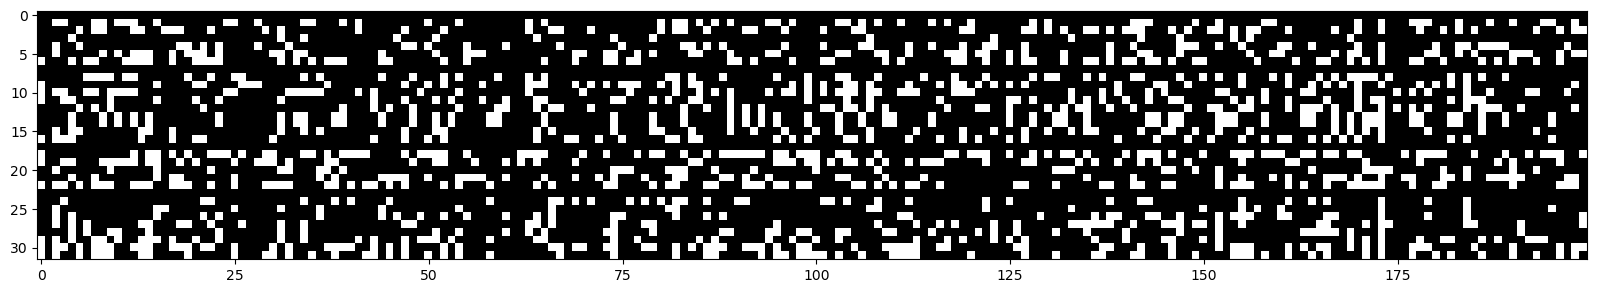

In [65]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap="grey", interpolation="nearest")
# > 0.99 is considered a flat region of tanh
# if an entire column is white, we have a dead nuron. it learns nothing
# it appears that all are learning. no pure white
# after multiplying w1 and b1 by 0.1 and 0.01 respectivtly we get no white

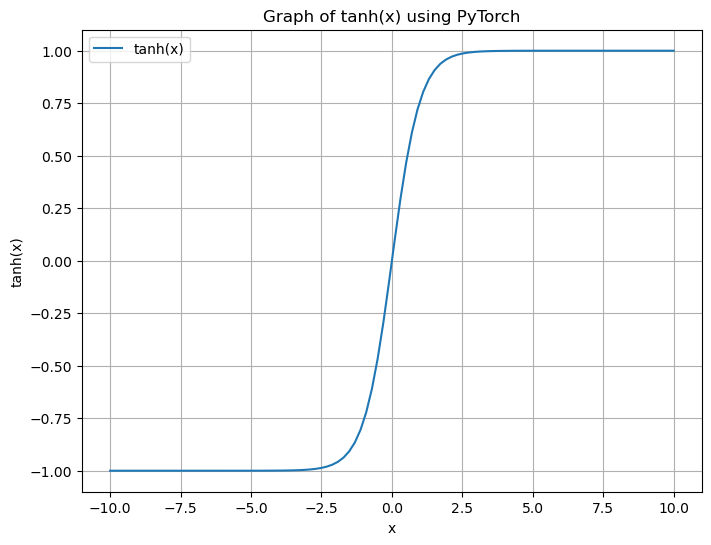

In [48]:
# Generate a range of values from -10 to 10 using PyTorch
x = torch.linspace(-10, 10, 100)
# Apply the tanh function using PyTorch
y = torch.tanh(x)

plt.figure(figsize=(8, 6))
plt.plot(x.numpy(), y.numpy(), label='tanh(x)')  # Converting tensors to numpy arrays for plotting
plt.title('Graph of tanh(x) using PyTorch')
plt.xlabel('x')
plt.ylabel('tanh(x)')
plt.grid(True)
plt.legend()
plt.show()


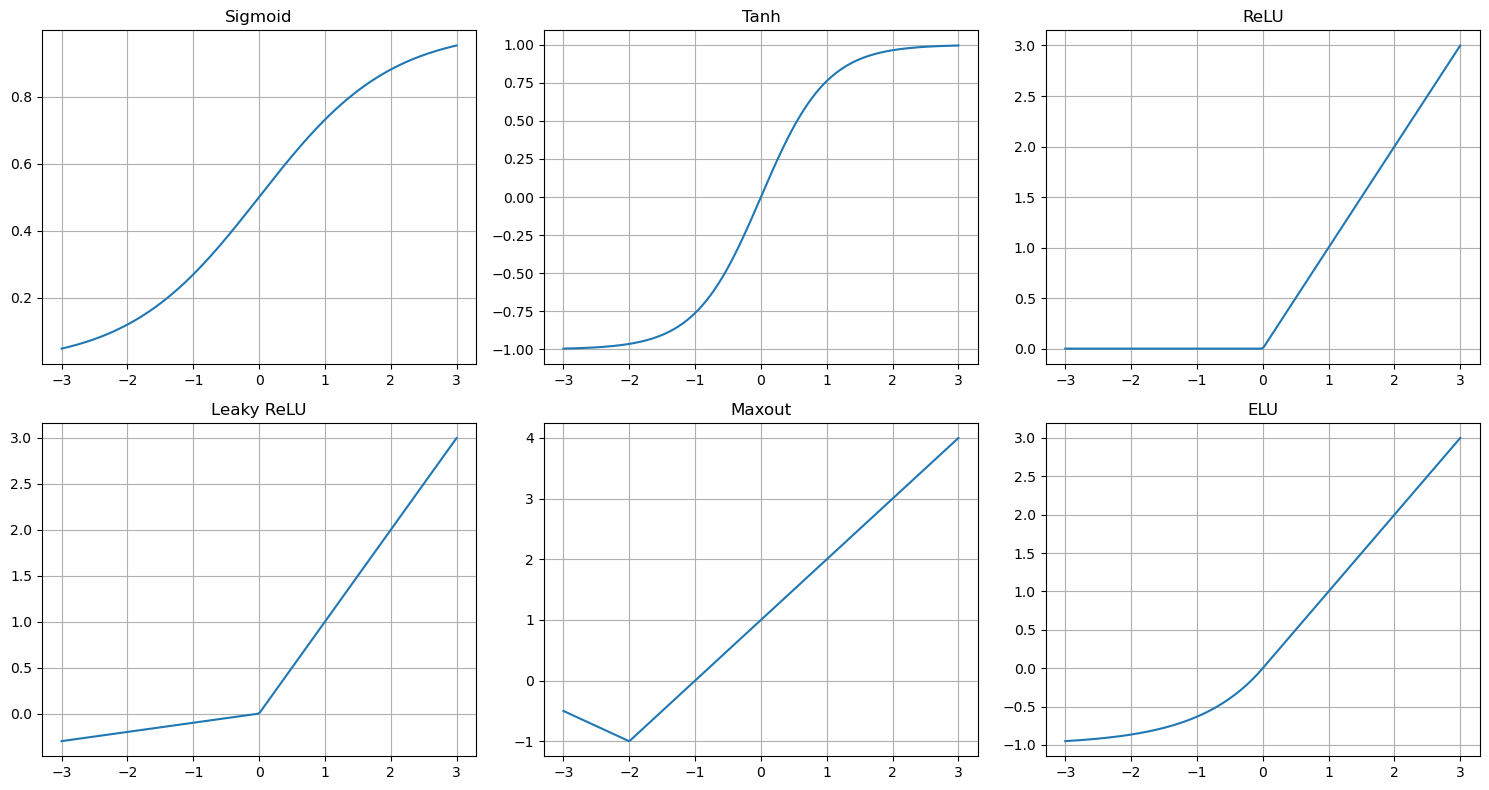

In [51]:


# Define the range of x values
x = np.linspace(-3, 3, 200)

# Activation Functions
def relu(x):
    return np.maximum(0, x)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def tanh(x):
    return np.tanh(x)

def maxout_example(x):
    # For demonstration, we'll just use two linear functions.
    w1, b1 = 1.0, 1.0  # Coefficients for the first linear piece
    w2, b2 = -0.5, -2.0  # Coefficients for the second linear piece
    return np.maximum(w1 * x + b1, w2 * x + b2)

def elu(x, alpha=1.0):
    return np.where(x > 0, x, alpha * (np.exp(x) - 1))

def leaky_relu(x, alpha=0.1):
    return np.where(x > 0, x, x * alpha)

# Define the plot layout
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Define a dictionary of functions to plot
activation_functions = {
    'Sigmoid': sigmoid,
    'Tanh': tanh,
    'ReLU': relu,
    'Leaky ReLU': leaky_relu,
    'Maxout': maxout_example,
    'ELU': elu,
}

# Plot the functions
for ax, (name, function) in zip(axes.flatten(), activation_functions.items()):
    y = function(x)
    ax.plot(x, y)
    ax.set_title(name)
    ax.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

# if a nueron with a relu non-linearity outputs a negative, it will never activate therefore it will never learn
# sometimes this can happen during training. Akin to brain damage
# others that have flat parts can have this happen


Sure, here are the mathematical representations of each activation function in Markdown format:

1. **Sigmoid:**
```markdown
\[
\sigma(x) = \frac{1}{1 + e^{-x}}
\]
```

2. **Tanh:**
```markdown
\[
\tanh(x) = \frac{e^{x} - e^{-x}}{e^{x} + e^{-x}}
\]
```

3. **ReLU (Rectified Linear Unit):**
```markdown
\[
\text{ReLU}(x) = \max(0, x)
\]
```

4. **Leaky ReLU:**
```markdown
\[
\text{Leaky ReLU}(x) = \begin{cases}
x & \text{if } x > 0, \\
0.01x & \text{otherwise}.
\end{cases}
\]
```

5. **Maxout (for the example provided, using two linear pieces):**
```markdown
\[
\text{Maxout}(x) = \max(w_1 x + b_1, w_2 x + b_2)
\]
```
(Note: `w_1`, `w_2`, `b_1`, and `b_2` are parameters that would be learned during training in a neural network.)

6. **ELU (Exponential Linear Unit):**
```markdown
\[
\text{ELU}(x) = \begin{cases}
x & \text{if } x \geq 0, \\
\alpha(e^{x} - 1) & \text{otherwise}.
\end{cases}
\]
```
(Note: `\alpha` is a hyperparameter that defines the value to which an ELU saturates for negative net inputs.)

You can use these representations in a Markdown cell to render the equations for the activation functions.

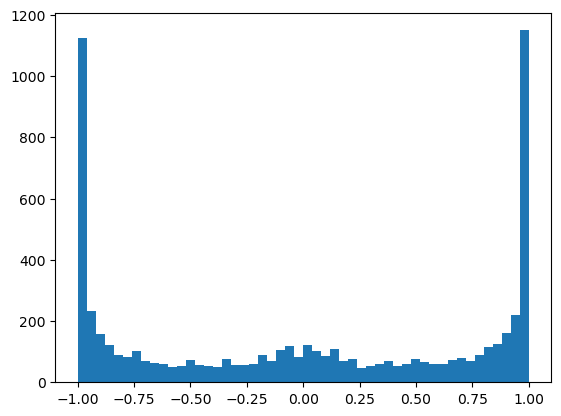

In [69]:
plt.hist(h.view(-1).tolist(),50);
# it's very active, most values are 1 or -1
# after W1 and b1 change, values are less extreme / not as close to -1 or 1

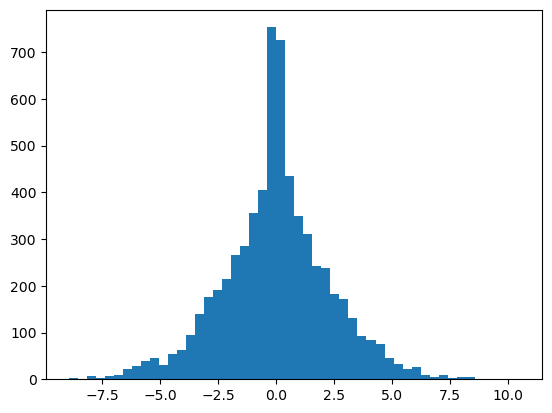

In [70]:
plt.hist(hpract.view(-1).tolist(),50);
# pre activations are very board, so the "squash" from tanh ends but having extremes
# these extremes lead to less learning so we want to fix this

In [42]:
# initial loss should be:
-torch.tensor(1/27.0).log()
# network is currently very confidently wrong.

tensor(3.2958)

In [26]:
# logits = torch.tensor([-3.0, 5.0, 0.0, 2.0])
# logits = torch.tensor([0.0, 0.0, 0.0, 0.0])
logits = torch.randn(4) * 10 # uniformly distributed
probs = torch.softmax(logits,dim=0)
loss = - probs[2].log()
logits, probs,loss
# this is a uniform distribution. All elements are equally likely
# if one of the logits happend to be much higher than the others then it would increaes the loss. 
# logits don't have to be zero, they just have to be equal to have a reasonable initial loss.

(tensor([ 13.7895, -14.5772,  -3.1877,   2.8867]),
 tensor([9.9998e-01, 4.7918e-13, 4.2356e-08, 1.8407e-05]),
 tensor(16.9772))

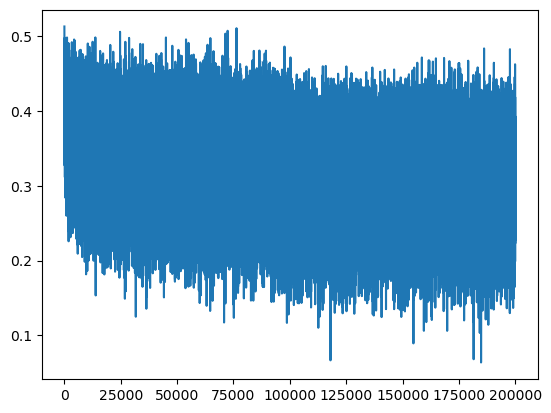

In [68]:
plt.plot(lossi)
# no longer a hockey stike becuase we took out the easy part. Now  we are spending more time actually optimizing

In [111]:
# calibrate the batch norm at the end of training
with torch.no_grad():
    # pass the training set (everything)
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpract = embcat @ W1 + b1
    bnmean = hpract.mean(0, keepdim=True)
    bnstd = hpract.std(0, keepdim=True)
# we can estimate this while training

In [113]:
bnmean_running


tensor([[-0.4439, -0.5302,  1.8514,  0.2699, -1.2561, -0.0984,  0.3120, -2.2260,
          0.6795, -0.6763, -1.8122,  0.0620, -1.3070,  0.2725,  1.6428,  0.1902,
          2.1422, -0.6498, -0.6185,  0.2913, -0.3491, -1.9192, -0.7782, -0.7356,
         -1.5106, -0.2667, -1.8609, -0.9340,  0.1281,  0.8356, -1.4445,  0.3896,
          0.9810,  1.3013,  1.4286, -1.4202,  1.0749,  1.3312, -2.5606, -0.2698,
         -2.2027, -1.1397, -1.3615, -2.0300, -0.2710,  1.9169, -1.1099, -0.2838,
         -0.7372, -1.8137, -0.4589, -2.4113,  0.2429,  0.8521, -1.1777, -0.1046,
         -1.0462, -2.5920, -0.5400, -1.5834,  0.2701,  0.6400,  2.3045, -0.0107,
          0.0859,  0.0755,  2.6410, -0.1476, -0.2687,  1.2564, -1.3782,  1.2169,
          0.6743,  0.8460, -1.5566,  0.8249, -1.5904,  1.5297, -0.5649, -0.6122,
         -1.0276, -1.2183,  1.3791, -0.4163,  0.8923, -0.1863, -0.6881,  0.1530,
         -1.2719, -2.8318, -0.2021, -0.1172, -0.1263,  2.1226, -0.4335,  1.0778,
         -1.1238, -1.0776, -

In [114]:
bnmean

tensor([[-0.4497, -0.5283,  1.8653,  0.2550, -1.2622, -0.0912,  0.3077, -2.2400,
          0.6803, -0.6837, -1.8211,  0.0576, -1.3057,  0.2668,  1.6608,  0.1926,
          2.1221, -0.6468, -0.6186,  0.3033, -0.3643, -1.9042, -0.7664, -0.7559,
         -1.5269, -0.2548, -1.8544, -0.9320,  0.1391,  0.8376, -1.4262,  0.3914,
          0.9794,  1.2887,  1.4294, -1.4245,  1.0628,  1.3257, -2.5512, -0.2728,
         -2.2038, -1.1471, -1.3510, -2.0288, -0.2596,  1.9363, -1.0880, -0.2871,
         -0.7442, -1.8007, -0.4592, -2.3930,  0.2276,  0.8553, -1.1605, -0.0994,
         -1.0340, -2.5851, -0.5521, -1.5642,  0.2781,  0.6229,  2.2950, -0.0099,
          0.0675,  0.0878,  2.6536, -0.1437, -0.2716,  1.2681, -1.3662,  1.2034,
          0.6732,  0.8408, -1.5486,  0.8266, -1.5852,  1.5343, -0.5721, -0.6277,
         -1.0230, -1.2081,  1.3659, -0.4260,  0.8698, -0.1722, -0.6848,  0.1587,
         -1.2583, -2.8315, -0.2101, -0.1233, -0.1230,  2.1345, -0.4352,  1.0851,
         -1.1205, -1.0757, -

In [116]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        "train": (Xtr,Ytr),
        "val":(Xdev,Ydev),
        "test": (Xte,Yte)
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0],-1)
    hpract = embcat @ W1 + b1
    # hpract = bngain *(hpract- bnmean / bnstd) + bnbias #batch normalization
    hpract = bngain *(hpract- bnmean_running/ bnstd_running) + bnbias #batch normalization
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits,y)
    print(split,loss.item())
split_loss("train")
split_loss("val")

train 3.0098137855529785
val 3.043362855911255


In [20]:
g = torch.Generator().manual_seed(214783647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1,-1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits,dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print("".join(itos[i] for i in out))

rvelle.
zolyn.
yanj.
elis.
leyan.
harin.
maxtonam.
lamwie.
kycethalra.
derliel.
hazael.
revia.
jiayne.
marl.
dariam.
okf.
cramora.
loyani.
eighlilly.
lyn.


Initialization is important. This network is small so we where still able to get results without further optimization but that may not be the case on larger networks. 
the deeper and more complex your network is the more is will suffer from this


He sped over the core paper that goes over how to best initialize weights of NN because of recent inovations that make training much more stable

normalization layers and optimizers

he still uses / 10**0.5

bath normalization what the first stab at the normalization and works well. It also regularizes / adds a bit of noise. This jitter / noise is caused by each batch being made up of different examples making thing a bit more non-deterministic
how do we feed in a single example now that is expects a batch

if you are using batch noramlization you likely should not use a bias in the layer before since is get substracted out but BN

BN has it's own bias


resnet uses a similar structure
1. weight layer / linear layer / convelusion
2. batch normalization
3. non-linearity or convelusion

avoid this layer as much as possible, he's shot himself in the foot a bunch with it. Alternatives are:
Root or Layer optimization (BN is 2015)

# https://youtu.be/P6sfmUTpUmc?si=Iy5gi6UDlrq6U8d5&t=4715